In [1]:
import pandas as pd
from collections import Counter
import regex as re
import grapheme
from sklearn.decomposition import PCA
from functools import partial
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.preprocessing as preprocessing
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import seaborn as sns

In [2]:
transcriptions = pd.read_excel('data/manuscript_data_metadata.xlsx')

# The id-column is a concatenation of the signature of the codex, the production unit, and the scribe of the unit
transcriptions['id'] = transcriptions['codex_sig'] + '-' + transcriptions['production unit'] + '-' + transcriptions['scribe']
transcriptions.head(5)

,Unnamed: 0,codex_sig,transkribuspage,image_filename,page_xml_filename,image_width,image_height,region_type,coordinates,fraction,...,content,language,scribe,production unit,local Herne product,date,translator,transcription,HTR-model used,id
0,0,Brussels KBR 1805-1808,7,0007_KBR_1805-08_1r.tiff,0007_KBR_1805-08_1r.xml,5186,7123,header,"1405,478 3598,478 3598,721 1405,721",0.01,...,proloog,middledutch,a,I,yes,1400,bibletranslator,GT,NaN,Brussels KBR 1805-1808-I-a
1,1,Brussels KBR 1805-1808,7,0007_KBR_1805-08_1r.tiff,0007_KBR_1805-08_1r.xml,5186,7123,paragraph,"1359,751 3792,751 3792,2645 1359,2645",0.12,...,proloog,middledutch,a,I,yes,1400,bibletranslator,GT,NaN,Brussels KBR 1805-1808-I-a
2,2,Brussels KBR 1805-1808,8,0008_KBR_1805-08_1v.tiff,0008_KBR_1805-08_1v.xml,5186,7123,paragraph,"1736,658 3985,658 3985,1643 1736,1643",0.06,...,proloog,middledutch,a,I,yes,1400,bibletranslator,GT,NaN,Brussels KBR 1805-1808-I-a
3,3,Brussels KBR 1805-1808,8,0008_KBR_1805-08_1v.tiff,0008_KBR_1805-08_1v.xml,5186,7123,marginalia,"2414,1705 4016,1705 4016,1851 2414,1851",0.01,...,proloog,middledutch,a,I,yes,1400,bibletranslator,GT,NaN,Brussels KBR 1805-1808-I-a
4,4,Brussels KBR 1805-1808,9,0009_KBR_1805-08_2r.tiff,0009_KBR_1805-08_2r.xml,5186,7123,paragraph,"859,5840 847,5678 835,5462 781,4838 751,4480 7...",0.23,...,dialogenGreg1_3,middledutch,α,I,yes,1395,bibletranslator,GT,NaN,Brussels KBR 1805-1808-I-α


In [3]:
transcriptions.loc[transcriptions['id'] == 'Vienna ÖNB 13.708-II-α', 'date'] = 1393

# Toon de resulterende DataFrame
transcriptions

,Unnamed: 0,codex_sig,transkribuspage,image_filename,page_xml_filename,image_width,image_height,region_type,coordinates,fraction,...,content,language,scribe,production unit,local Herne product,date,translator,transcription,HTR-model used,id
0,0,Brussels KBR 1805-1808,7,0007_KBR_1805-08_1r.tiff,0007_KBR_1805-08_1r.xml,5186,7123,header,"1405,478 3598,478 3598,721 1405,721",0.01,...,proloog,middledutch,a,I,yes,1400,bibletranslator,GT,NaN,Brussels KBR 1805-1808-I-a
1,1,Brussels KBR 1805-1808,7,0007_KBR_1805-08_1r.tiff,0007_KBR_1805-08_1r.xml,5186,7123,paragraph,"1359,751 3792,751 3792,2645 1359,2645",0.12,...,proloog,middledutch,a,I,yes,1400,bibletranslator,GT,NaN,Brussels KBR 1805-1808-I-a
2,2,Brussels KBR 1805-1808,8,0008_KBR_1805-08_1v.tiff,0008_KBR_1805-08_1v.xml,5186,7123,paragraph,"1736,658 3985,658 3985,1643 1736,1643",0.06,...,proloog,middledutch,a,I,yes,1400,bibletranslator,GT,NaN,Brussels KBR 1805-1808-I-a
3,3,Brussels KBR 1805-1808,8,0008_KBR_1805-08_1v.tiff,0008_KBR_1805-08_1v.xml,5186,7123,marginalia,"2414,1705 4016,1705 4016,1851 2414,1851",0.01,...,proloog,middledutch,a,I,yes,1400,bibletranslator,GT,NaN,Brussels KBR 1805-1808-I-a
4,4,Brussels KBR 1805-1808,9,0009_KBR_1805-08_2r.tiff,0009_KBR_1805-08_2r.xml,5186,7123,paragraph,"859,5840 847,5678 835,5462 781,4838 751,4480 7...",0.23,...,dialogenGreg1_3,middledutch,α,I,yes,1395,bibletranslator,GT,NaN,Brussels KBR 1805-1808-I-α
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15917,15917,Vienna ÖNB 65,193,00000193.jpg,00000193.xml,1944,2598,paragraph,"952,250 1747,250 1747,2108 952,2108",0.29,...,horlogium,middledutch,γ,IV,yes,1375-1400,NaN,HTR,BigMiddleDutchModel_v2,Vienna ÖNB 65-IV-γ
15918,15918,Vienna ÖNB 65,193,00000193.jpg,00000193.xml,1944,2598,marginalia,"1757,1097 1757,1185 1825,1187 1825,1099",0.00,...,horlogium,middledutch,γ,IV,yes,1375-1400,NaN,HTR,BigMiddleDutchModel_v2,Vienna ÖNB 65-IV-γ
15919,15919,Vienna ÖNB 65,194,00000194.jpg,00000194.xml,1932,2625,paragraph,"281,276 281,2114 1029,2114 1029,276",0.27,...,horlogium,middledutch,γ,IV,yes,1375-1400,NaN,HTR,BigMiddleDutchModel_v2,Vienna ÖNB 65-IV-γ
15920,15920,Vienna ÖNB 65,194,00000194.jpg,00000194.xml,1932,2625,paragraph,"1105,276 1106,578 1866,578 1865,276",0.05,...,horlogium,middledutch,γ,IV,yes,1375-1400,NaN,HTR,BigMiddleDutchModel_v2,Vienna ÖNB 65-IV-γ


In [4]:
# We merge together all text from the same production units.

units = []
plain_char = re.compile("[A-Za-z]+")

for prod_unit_id, prod_unit in transcriptions.groupby('id'):
    prod_unit = prod_unit.sort_values('transkribuspage')
    prod_unit = prod_unit[~prod_unit['text'].isna()]
    if not len(prod_unit):
        continue
    # Eerst worden alle tekstfragmenten samengevoegd met behoud van de huidige nieuwe regels
    text = '\n'.join(t for t in prod_unit['text'])

    # Vervolgens worden overtollige spaties verwijderd en nieuwe regels toegevoegd tussen elk tekstfragment
    text = '\n'.join(' '.join(line.strip().split()) for line in text.split('\n'))

    
    date = prod_unit.sample(1)['date'].values[0]
    scribe = prod_unit.sample(1)['scribe'].values[0]
    sig = prod_unit.sample(1)['codex_sig'].values[0]
    content = '<UNK>'
    try:
        content = ' - '.join(Counter(prod_unit['content']))
    except:
        pass
    
    try:
        if plain_char.fullmatch(scribe):
            scribe = sig + '-' + scribe
    except TypeError:
        scribe = '<UNK>'
        
    translator = prod_unit.sample(1)['translator'].values[0]
    units.append((prod_unit_id, date, text, scribe, sig, prod_unit_id, translator, content))

H = pd.DataFrame(units, columns=['pu', 'date', 'text', 'scribe', 'signature', 'id', 'translator', 'content'])
H

,pu,date,text,scribe,signature,id,translator,content
0,Brussels KBR 1805-1808-I-a,1400,Een voorredene op sinte gregoriꝰ dyalogus\nDE ...,Brussels KBR 1805-1808-a,Brussels KBR 1805-1808,Brussels KBR 1805-1808-I-a,bibletranslator,proloog
1,Brussels KBR 1805-1808-I-α,1395,Hier beghint een voʼredene\nop .Sʼ. gᵉgorius d...,α,Brussels KBR 1805-1808,Brussels KBR 1805-1808-I-α,bibletranslator,dialogenGreg1_3
2,Brussels KBR 1805-1808-II-D,1395,Hiʼ begēt de pierde boec vā gᵉgerna\n¶ Dyalogu...,Brussels KBR 1805-1808-D,Brussels KBR 1805-1808,Brussels KBR 1805-1808-II-D,bibletranslator,dialogenGreg4
3,Brussels KBR 1805-1808-II-α,1395,De dʼde boec gaꝫ hiʼ vte Hiʼ volgen\ndē capite...,α,Brussels KBR 1805-1808,Brussels KBR 1805-1808-II-α,none,inhoudsopgave
4,Brussels KBR 1805-1808-III-none,1395,DJt boec hoert den bruedʼs vādē goede cloestin...,Brussels KBR 1805-1808-none,Brussels KBR 1805-1808,Brussels KBR 1805-1808-III-none,none,none
...,...,...,...,...,...,...,...,...
118,Vienna ÖNB 65-I-a,1375-1400,liber iste ꝑtinet ad cenob sā pauli zonia\nDo...,Vienna ÖNB 65-a,Vienna ÖNB 65,Vienna ÖNB 65-I-a,NaN,note
119,Vienna ÖNB 65-I-γ,1375-1400,‡ d\nblie die pase on heeren ihoes\nso voerga ...,γ,Vienna ÖNB 65,Vienna ÖNB 65-I-γ,NaN,TOC
120,Vienna ÖNB 65-II-α,1375-1400,huiꝰ lcōt corrigat librū qui valde īcorrectꝰ ē...,α,Vienna ÖNB 65,Vienna ÖNB 65-II-α,NaN,horlogium
121,Vienna ÖNB 65-III-γ,1375-1400,vᵃ\nDe wijsheit . Dat en mach niet sijn .\nNoc...,γ,Vienna ÖNB 65,Vienna ÖNB 65-III-γ,NaN,horlogium


In [5]:
# H[H['signature'] == 'Vienna ÖNB 13.708']['date'].unique()

In [6]:
# Pas de 'date' aan voor 'Vienna ÖNB 13.708' als deze niet gelijk is aan 1402
# H.loc[(H['signature'] == 'Vienna ÖNB 13.708') & (H['date'] == '1394'), 'date'] = '1393-1394'

# Toon de resulterende DataFrame
# H[H['signature'] == 'Vienna ÖNB 13.708']['date'].unique()

In [7]:
# If a date is approximated (f.e. 1325-1350), we have to convert it 
# to one single year in order to work with it. Accordingly, we calculate
# the mean and store it in the 'num_date'-column

num_dates = []

for d in H['date']:
    if d in ('unknown', 'no', 'none'):
        d = None
    else:
        try:
            d = int(d)
        except ValueError:
            if '-' in d:
                d1, d2 = d.split('-')
                d1, d2 = int(d1), int(d2)
                d = d1 + ((d2 - d1) / 2)
    num_dates.append(d)
    
H['num_date'] = num_dates
H['length'] = H['text'].str.len()
H = H.sort_values('num_date')
H

,pu,date,text,scribe,signature,id,translator,content,num_date,length
82,Saint Petersburg BAN O 256-II-G,1325-1350,es and net aeroeg ē en wna\nM8\nSadoch ghebaer...,Saint Petersburg BAN O 256-G,Saint Petersburg BAN O 256,Saint Petersburg BAN O 256-II-G,NaN,evangMath,1337.5,108874
80,Saint Petersburg BAN O 256-I-B,1325-1350,Vandē i maghede .\nOsluestʼs dach mᵗ xxiiij.\n...,Saint Petersburg BAN O 256-B,Saint Petersburg BAN O 256,Saint Petersburg BAN O 256-I-B,NaN,perikopen,1337.5,4543
81,Saint Petersburg BAN O 256-I-II-B-G,1325-1350,E nedʼ gaende .\nOp alre heilighē . dʼ mᵗ .v....,B-G,Saint Petersburg BAN O 256,Saint Petersburg BAN O 256-I-II-B-G,NaN,perikoken-evangMath,1337.5,1537
26,Brussels KBR 2879-80-III-C,1325-1350,Ay Ay edele vol redenē waer moe-\nghedi dueren...,Brussels KBR 2879-80-C,Brussels KBR 2879-80,Brussels KBR 2879-80-III-C,none,HadLied - HadLied-HadMeng - HadMeng,1337.5,118389
25,Brussels KBR 2879-80-III-B-C,1325-1350,mi dat ic di ꝟwinne Jn dine onuʼ-\nwonnene cra...,B-C,Brussels KBR 2879-80,Brussels KBR 2879-80-III-B-C,none,HadLied,1337.5,2264
...,...,...,...,...,...,...,...,...,...,...
76,Paris Bibliothèque de l'Arsenal 8224-none-none,none,d gostste\nNut Jaer ons hʼoerdei gh ei oegod ...,Paris Bibliothèque de l'Arsenal 8224-none,Paris Bibliothèque de l'Arsenal 8224,Paris Bibliothèque de l'Arsenal 8224-none-none,NaN,schenkingsnotitie,NaN,1093
77,Paris Bibliothèque de l'Arsenal 8224-none-unknown,none,de on\nAʼsic sommē frusten .\ncfit Sn iichul m...,Paris Bibliothèque de l'Arsenal 8224-unknown,Paris Bibliothèque de l'Arsenal 8224,Paris Bibliothèque de l'Arsenal 8224-none-unknown,NaN,vulgaat,NaN,1711
89,Saint Petersburg BAN O 256-none-none,none,\n,Saint Petersburg BAN O 256-none,Saint Petersburg BAN O 256,Saint Petersburg BAN O 256-none-none,NaN,none,NaN,1
95,Vienna ÖNB 12.857-none-none,no,. Die .iiij. euangelisten .,Vienna ÖNB 12.857-none,Vienna ÖNB 12.857,Vienna ÖNB 12.857-none-none,NaN,none,NaN,27


In [8]:
# Filters out any short text with a length less than 1000 characters

print(len(H))
H = H[H['length'] > 1000]
print(len(H))

123
92


In [9]:
H['text'][:10]

82    es and net aeroeg ē en wna\nM8\nSadoch ghebaer...
80    Vandē i maghede .\nOsluestʼs dach mᵗ xxiiij.\n...
81    E nedʼ gaende .\nOp alre heilighē . dʼ mᵗ .v....
26    Ay Ay edele vol redenē waer moe-\nghedi dueren...
25    mi dat ic di ꝟwinne Jn dine onuʼ-\nwonnene cra...
24    AY al es nu die winter cout\nCort de daghe e ...
23    HEt was in ene sōdage\ntʼ octauē vā pētecostē\...
22    Niet opten loen Si beuelēt\nalder minnen dies ...
21    beidē vloeyende E si beide\neen dore hem selu...
20    GOd die de clare Mᵉ\ndie onbekint was\nvʼclaer...
Name: text, dtype: object

In [10]:
# we only use the ground truth transcriptions (not the HTR transcriptions).
# That way, we are sure no artifacts of the model are included.

allowed_chars = ''.join([t for t in transcriptions[transcriptions['transcription'] == 'GT']['text'] if isinstance(t, str)])
allowed_chars = Counter(allowed_chars)
print(allowed_chars)

plain_char = re.compile("[A-Za-z]+")

# the following characters are also brevigraphs, but we need to add them
# manually, otherwise they're recognised as punctuation
unicode_brevigraphs = [u'\ue5dc', u'\ue554', u'\ue5b8', u'\ue665', u'ᷣ', u'̄', u'᷑',
                  u'\ue74d', u'\ue8e5', u'\ueed7', u'\ue681', u'\ue1dc', u'\ue154']

letters, brevigraphs, punctuation = [], [], []

for g, c in allowed_chars.items():
    # ignore:
    if g.isnumeric():
        continue
    if g.isspace():
        continue
    if plain_char.fullmatch(g):
        letters.append((g, c))
    elif g.isalpha() or g in unicode_brevigraphs:  # Include the custom-defined Unicode brevigraphs!!
        brevigraphs.append((g, c))
    else:
        punctuation.append((g, c))

letters = Counter(dict(letters))
brevigraphs = Counter(dict(brevigraphs))
punctuation = Counter(dict(punctuation))

# Now, we clean the text of the HTR transcriptions based on the 
# ground truth characters that we transcribed. That way, possible 'weird' 
# characters that the model recognised, are excluded.
# In other words, we only keep characters that are attested in the 
# ground truth transcriptions.

def clean(text):
    # text = ' '.join(text.split()) # delete unnecessary whitespace # keep \n

    return ''.join([c for c in text if c in allowed_chars])

H['text'] = H['text'].apply(clean)
H

Counter({' ': 271155, 'e': 219885, 'd': 73321, 't': 72149, 'i': 69673, 'n': 66138, 's': 64772, 'a': 52343, 'h': 47921, 'o': 47400, 'l': 45013, '\n': 44272, 'ē': 44220, 'r': 37095, 'g': 32348, 'c': 32102, 'm': 27462, 'ʼ': 24453, 'u': 20743, 'w': 19799, 'v': 17397, '.': 17338, 'b': 14561, '\ue5dc': 12806, ':': 9737, 'k': 9132, 'ī': 9096, 'ā': 8606, 'p': 8213, 'ꝫ': 7334, 'D': 7085, '-': 6872, 'f': 6049, 'E': 5507, 'ō': 5388, 'j': 4927, 'ᵗ': 3334, '\ue554': 2245, 'W': 2162, 'y': 2087, 'S': 2021, 'x': 1894, 'H': 1796, 'M': 1789, 'A': 1613, 'J': 1586, 'ᵃ': 1491, 'ᵒ': 1400, 'z': 1361, 'ᵉ': 1215, 'V': 1139, 'N': 1125, 'ꝟ': 1098, 'q': 1027, 'O': 880, 'ꝰ': 849, 'G': 821, 'ⁱ': 744, '¶': 737, 'T': 518, 'B': 448, 'ⁿ': 393, '̄': 388, 'ꝑ': 320, '\ue5b8': 308, 'ū': 301, 'ᵛ': 291, '\ue665': 275, 'ꝓ': 247, 'I': 230, 'ᷣ': 214, '⸫': 212, 'L': 183, 'ꝯ': 180, 'C': 176, '‡': 149, '|': 131, '\uf160': 124, 'R': 123, 'Z': 120, '1': 118, 'Ō': 117, 'P': 102, '3': 95, '2': 92, '‸': 81, '4': 71, '6': 53, '᷑': 49, '

/var/folders/qv/jgq1ttws58g43xdmt2gthgth0000gn/T/ipykernel_59674/2750928448.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  H['text'] = H['text'].apply(clean)


,pu,date,text,scribe,signature,id,translator,content,num_date,length
82,Saint Petersburg BAN O 256-II-G,1325-1350,es and net aeroeg ē en wna\nM8\nSadoch ghebaer...,Saint Petersburg BAN O 256-G,Saint Petersburg BAN O 256,Saint Petersburg BAN O 256-II-G,NaN,evangMath,1337.5,108874
80,Saint Petersburg BAN O 256-I-B,1325-1350,Vandē i maghede .\nOsluestʼs dach mᵗ xxiiij.\n...,Saint Petersburg BAN O 256-B,Saint Petersburg BAN O 256,Saint Petersburg BAN O 256-I-B,NaN,perikopen,1337.5,4543
81,Saint Petersburg BAN O 256-I-II-B-G,1325-1350,E nedʼ gaende .\nOp alre heilighē . dʼ mᵗ .v....,B-G,Saint Petersburg BAN O 256,Saint Petersburg BAN O 256-I-II-B-G,NaN,perikoken-evangMath,1337.5,1537
26,Brussels KBR 2879-80-III-C,1325-1350,Ay Ay edele vol redenē waer moe-\nghedi dueren...,Brussels KBR 2879-80-C,Brussels KBR 2879-80,Brussels KBR 2879-80-III-C,none,HadLied - HadLied-HadMeng - HadMeng,1337.5,118389
25,Brussels KBR 2879-80-III-B-C,1325-1350,mi dat ic di ꝟwinne Jn dine onuʼ-\nwonnene cra...,B-C,Brussels KBR 2879-80,Brussels KBR 2879-80-III-B-C,none,HadLied,1337.5,2264
...,...,...,...,...,...,...,...,...,...,...
27,Brussels KBR 2905-09-I-unknown,1400-1450,Januamius\nNoumaēt .xxxi dage demane .xxx.\nMa...,Brussels KBR 2905-09-unknown,Brussels KBR 2905-09,Brussels KBR 2905-09-I-unknown,NaN,kalender,1425.0,5428
92,Vienna ÖNB 12.857-III-C,1450,DJer beghint die tofele hoe men vijnden sal\nd...,Vienna ÖNB 12.857-C,Vienna ÖNB 12.857,Vienna ÖNB 12.857-III-C,NaN,perikopen,1450.0,10295
90,Vienna ÖNB 12.857-I-A,1450-1500,¶ Dit es een vʼclarīghe hoe men\ndie ewāgelien...,Vienna ÖNB 12.857-A,Vienna ÖNB 12.857,Vienna ÖNB 12.857-I-A,NaN,proloog,1475.0,2186
76,Paris Bibliothèque de l'Arsenal 8224-none-none,none,d gostste\nNut Jaer ons hʼoerdei gh ei oegod ...,Paris Bibliothèque de l'Arsenal 8224-none,Paris Bibliothèque de l'Arsenal 8224,Paris Bibliothèque de l'Arsenal 8224-none-none,NaN,schenkingsnotitie,NaN,1093


In [11]:
H['text'][:10]

82    es and net aeroeg ē en wna\nM8\nSadoch ghebaer...
80    Vandē i maghede .\nOsluestʼs dach mᵗ xxiiij.\n...
81    E nedʼ gaende .\nOp alre heilighē . dʼ mᵗ .v....
26    Ay Ay edele vol redenē waer moe-\nghedi dueren...
25    mi dat ic di ꝟwinne Jn dine onuʼ-\nwonnene cra...
24    AY al es nu die winter cout\nCort de daghe e ...
23    HEt was in ene sōdage\ntʼ octauē vā pētecostē\...
22    Niet opten loen Si beuelēt\nalder minnen dies ...
21    beidē vloeyende E si beide\neen dore hem selu...
20    GOd die de clare Mᵉ\ndie onbekint was\nvʼclaer...
Name: text, dtype: object

In [12]:
# We remove punctuation

hyphenation_break = re.compile(r'\-\s+')
numeric = re.compile(r'[0-9]+')

def rm_punct(text):
    text = re.sub(hyphenation_break, '', text) # detecting hyphenation breaks, deleting them
    text = re.sub(numeric, '', text) # detecting numeric characters, deleting them
    return ''.join([c for c in text if c not in punctuation]) # deleting punctuation

H['text'] = H['text'].apply(rm_punct)
H

/var/folders/qv/jgq1ttws58g43xdmt2gthgth0000gn/T/ipykernel_59674/2140627523.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  H['text'] = H['text'].apply(rm_punct)


,pu,date,text,scribe,signature,id,translator,content,num_date,length
82,Saint Petersburg BAN O 256-II-G,1325-1350,es and net aeroeg ē en wna\nM\nSadoch ghebaer ...,Saint Petersburg BAN O 256-G,Saint Petersburg BAN O 256,Saint Petersburg BAN O 256-II-G,NaN,evangMath,1337.5,108874
80,Saint Petersburg BAN O 256-I-B,1325-1350,Vandē i maghede \nOsluestʼs dach mᵗ xxiiij\nWa...,Saint Petersburg BAN O 256-B,Saint Petersburg BAN O 256,Saint Petersburg BAN O 256-I-B,NaN,perikopen,1337.5,4543
81,Saint Petersburg BAN O 256-I-II-B-G,1325-1350,E nedʼ gaende \nOp alre heilighē dʼ mᵗ v\nE...,B-G,Saint Petersburg BAN O 256,Saint Petersburg BAN O 256-I-II-B-G,NaN,perikoken-evangMath,1337.5,1537
26,Brussels KBR 2879-80-III-C,1325-1350,Ay Ay edele vol redenē waer moeghedi dueren J...,Brussels KBR 2879-80-C,Brussels KBR 2879-80,Brussels KBR 2879-80-III-C,none,HadLied - HadLied-HadMeng - HadMeng,1337.5,118389
25,Brussels KBR 2879-80-III-B-C,1325-1350,mi dat ic di ꝟwinne Jn dine onuʼwonnene cracht...,B-C,Brussels KBR 2879-80,Brussels KBR 2879-80-III-B-C,none,HadLied,1337.5,2264
...,...,...,...,...,...,...,...,...,...,...
27,Brussels KBR 2905-09-I-unknown,1400-1450,Januamius\nNoumaēt xxxi dage demane xxx\nMaers...,Brussels KBR 2905-09-unknown,Brussels KBR 2905-09,Brussels KBR 2905-09-I-unknown,NaN,kalender,1425.0,5428
92,Vienna ÖNB 12.857-III-C,1450,DJer beghint die tofele hoe men vijnden sal\nd...,Vienna ÖNB 12.857-C,Vienna ÖNB 12.857,Vienna ÖNB 12.857-III-C,NaN,perikopen,1450.0,10295
90,Vienna ÖNB 12.857-I-A,1450-1500,Dit es een vʼclarīghe hoe men\ndie ewāgelien ...,Vienna ÖNB 12.857-A,Vienna ÖNB 12.857,Vienna ÖNB 12.857-I-A,NaN,proloog,1475.0,2186
76,Paris Bibliothèque de l'Arsenal 8224-none-none,none,d gostste\nNut Jaer ons hʼoerdei gh ei oegod ...,Paris Bibliothèque de l'Arsenal 8224-none,Paris Bibliothèque de l'Arsenal 8224,Paris Bibliothèque de l'Arsenal 8224-none-none,NaN,schenkingsnotitie,NaN,1093


In [13]:
H['text'][:10]

82    es and net aeroeg ē en wna\nM\nSadoch ghebaer ...
80    Vandē i maghede \nOsluestʼs dach mᵗ xxiiij\nWa...
81    E nedʼ gaende \nOp alre heilighē  dʼ mᵗ v\nE...
26    Ay Ay edele vol redenē waer moeghedi dueren  J...
25    mi dat ic di ꝟwinne Jn dine onuʼwonnene cracht...
24    AY al es nu die winter cout\nCort de daghe e ...
23    HEt was in ene sōdage\ntʼ octauē vā pētecostē\...
22    Niet opten loen Si beuelēt\nalder minnen dies ...
21    beidē vloeyende E si beide\neen dore hem selu...
20    GOd die de clare Mᵉ\ndie onbekint was\nvʼclaer...
Name: text, dtype: object

In [14]:
segment_size = 5000
segments = []

for _, row in H.iterrows():
    text = row['text']
    graphemes = list(grapheme.graphemes(text))
    
    starting_index, ending_index = 0, segment_size
    while ending_index < len(graphemes):
        segment_graphemes = graphemes[starting_index:ending_index]
        segment_text = ''.join(segment_graphemes)
        
        segments.append((segment_text, row['num_date'], row['scribe'], row['signature'], row['id'], row['translator'], row['content']))
        
        starting_index += segment_size
        ending_index += segment_size

segments = pd.DataFrame(segments, columns=['text', 'date', 'scribe', 'signature', 'id', 'translator', 'content'])
segments.sample(5)

,text,date,scribe,signature,id,translator,content
959,onsē\ngod E dꝫ si wachtē e voldoē alle de wa...,1387.5,α,Brussels KBR 2849-51,Brussels KBR 2849-51-VII-α,NaN,perikopenOT
981,vā ge\nslechtē vā starcheidē vā scoēheidē v...,1387.5,α,Brussels KBR 2905-09,Brussels KBR 2905-09-II-α,NaN,inhoudsopgave - inhoudsopgave-proloog - proloo...
799,die diepste vloet\nDie grondeloes es e altoe...,1387.5,Ghent UB 941-B,Ghent UB 941,Ghent UB 941-II-B,NaN,HadBrief - HadBrief-HadLied - HadLied - Tweevo...
1369,escoʼt\nE starf also hi hadde vʼboʼt\n Dit ho...,1402.0,α,Vienna ÖNB 13.708,Vienna ÖNB 13.708-VI-α,NaN,sph2-4
1349,wesē si\nDes leuēde gods teekijn\nE dꝫ teek...,1402.0,α,Vienna ÖNB 13.708,Vienna ÖNB 13.708-VII-α,NaN,sph2-5 - bibliasacra+antiquitates


In [15]:
# Create n-grams with the option to explicitly include brevigraphs or not
# and to incorporate graphemic or not

def ngrams(text, ngram_size=1, brevigraphs_only=True, graphemic=True):
    if graphemic:
        chars = [g for g in grapheme.graphemes(text) if g]
    else:
        chars = list(unicodedata.normalize('NFC', text))
    
    for idx in range(len(chars)-(ngram_size-1)):
        gram = text[idx:idx+ngram_size]
        if '\n' in gram:
            continue  # Ignore n-grams containing '\n'
        if brevigraphs_only:
            brevigraph_present = False
            for char in gram:
                if char in brevigraphs:
                    brevigraph_present = True
            if brevigraph_present:
                yield gram
            else:
                continue
        else:
            yield ''.join(gram)
    
params = {'use_idf': True,
          'max_features': 100,
          'analyzer': partial(ngrams,
                              graphemic=True,
                              ngram_size=2,
                              brevigraphs_only=True),
          'min_df': 2}

vectorizer = TfidfVectorizer(**params)
BOW = vectorizer.fit_transform(segments['text']).toarray()
BOW = preprocessing.scale(BOW)
BOW.shape # amount of segments x number of features
BOW_df = pd.DataFrame(BOW, columns=vectorizer.get_feature_names_out())

print(BOW.shape) # amount of segments x number of features
BOW_df

(1493, 100)


,ā,ē,ī,ō,ꝟ,E,Wā,aē,aʼ,bē,...,ʼw,ᵃc,ᵃm,ᵒe,ᵒt,ᵗ,ꝫ,ꝰ,,
0,0.573573,-0.588862,-0.079649,-0.024733,-0.035600,0.780113,-0.914360,0.707696,-0.798871,0.570903,...,-0.800552,-0.602836,1.602003,-0.127277,-0.176158,-0.916910,0.067961,-0.607548,-0.877773,0.545297
1,0.567050,-0.803402,-0.303158,-0.177626,-0.231061,1.064454,-0.914360,0.115963,-0.798871,0.033016,...,0.304362,-0.220399,1.041670,2.710478,-0.638751,-0.916910,0.206752,-0.200239,-0.661691,0.747824
2,-0.680536,-0.803402,-0.305337,-0.179692,-0.424499,-0.486678,-0.914360,0.695043,-0.668195,2.673462,...,0.302141,-0.602836,0.490610,2.136620,-0.638751,-0.916910,1.442567,-0.404303,-0.446478,-0.844588
3,-0.680536,-0.803402,-0.019702,-0.065551,-0.049051,-0.365808,-0.914360,0.646930,-0.798871,0.001730,...,-0.800552,-0.602836,-0.604888,2.609784,-0.638751,-0.916910,0.374054,-0.212271,-0.038976,-0.469019
4,-0.139448,-0.803402,-0.634796,-0.059232,-0.424499,1.327432,-0.512030,1.224859,-0.798871,2.189422,...,1.116291,0.392361,1.775533,2.258519,-0.239578,-0.916910,0.510170,-0.607548,-0.128040,1.438003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1488,-0.680536,0.369332,-0.493617,-0.196917,-0.424499,-0.587167,-0.277198,0.151248,2.618715,-1.026144,...,-0.800552,-0.077478,-0.604888,0.862540,1.257737,0.246792,-0.323608,3.029361,0.012729,-1.143686
1489,-0.680536,1.194115,-0.372574,-0.420034,-0.424499,0.577761,0.946116,2.456089,2.527513,2.514235,...,-0.800552,0.419840,0.128956,0.061246,1.207127,0.782061,0.235438,1.026231,0.855704,0.574169
1490,-0.680536,1.325366,-0.170842,-0.655990,-0.424499,0.543220,1.977111,0.766710,1.649944,0.294409,...,1.265846,2.258081,1.448029,1.426684,0.508763,0.139277,0.221026,2.439430,1.277502,-0.053242
1491,-0.680536,0.014317,-1.386707,-1.204908,-0.424499,-1.296688,-0.914360,-0.491185,-0.046344,-1.026144,...,-0.800552,-0.602836,0.446555,-0.698393,-0.638751,-0.916910,-0.487387,4.074170,-0.877773,-0.864670


In [16]:
BOW_df.columns

Index([' ā', ' ē', ' ī', ' ō', ' ꝟ', 'E', 'Wā', 'aē', 'aʼ', 'bē', 'dā', 'dē',
       'dī', 'dʼ', 'dꝫ', 'eʼ', 'e', 'gē', 'gᵒ', 'hā', 'hē', 'hʼ', 'hᵗ', 'hꝫ',
       'iē', 'iʼ', 'i', 'kē', 'kī', 'kʼ', 'lē', 'lʼ', 'mā', 'mē', 'mī', 'mʼ',
       'mꝫ', 'nē', 'nᵗ', 'oē', 'oʼ', 'oꝫ', 'pē', 'qᵃ', 'rē', 'sē', 'sō', 'tē',
       'tʼ', 'uē', 'uʼ', 'vā', 'vʼ', 'wā', 'wē', 'wʼ', 'ā ', 'ād', 'āt', 'ē ',
       'ēd', 'ēn', 'ēs', 'ēt', 'ī ', 'īc', 'īd', 'īg', 'īn', 'īt', 'ō ', 'ōd',
       'ōg', 'ōm', 'ōs', 'ōt', 'ʼ ', 'ʼc', 'ʼd', 'ʼe', 'ʼg', 'ʼh', 'ʼk', 'ʼl',
       'ʼm', 'ʼn', 'ʼr', 'ʼs', 'ʼt', 'ʼu', 'ʼw', 'ᵃc', 'ᵃm', 'ᵒe', 'ᵒt', 'ᵗ ',
       'ꝫ ', 'ꝰ ', ' ', ' '],
      dtype='object')

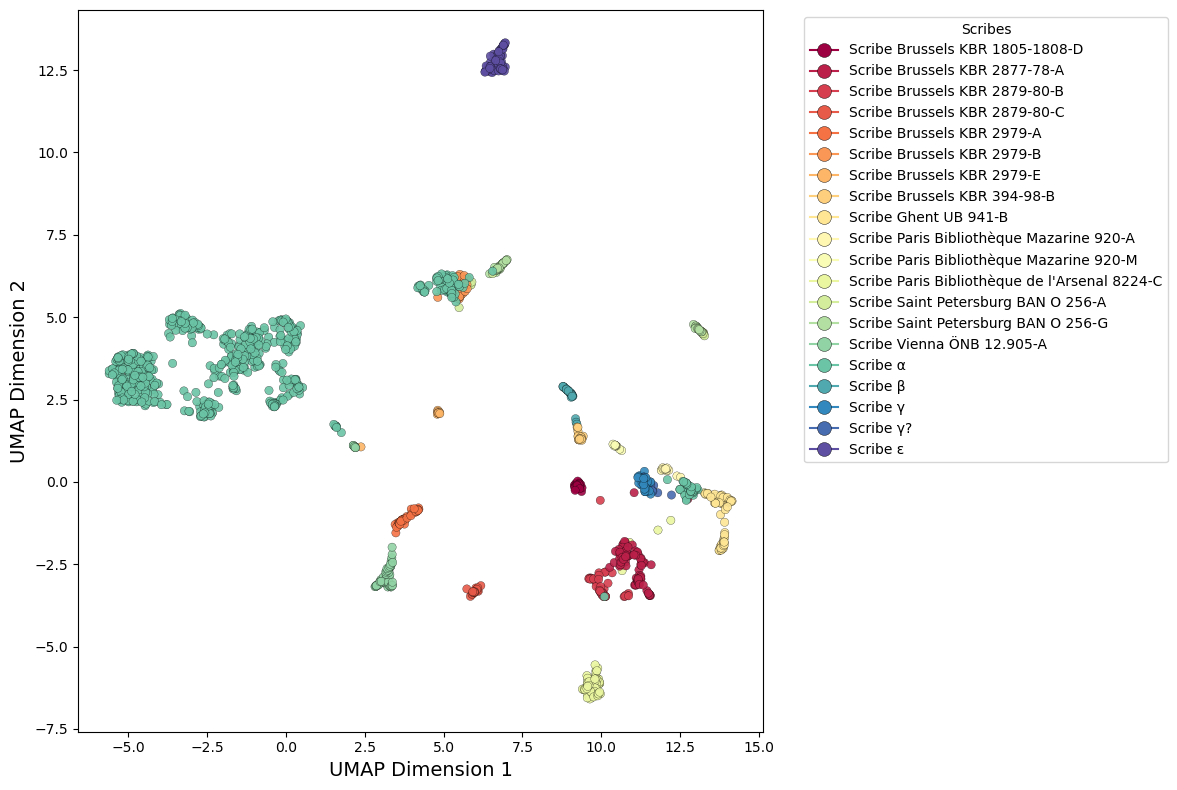

In [17]:
import umap.umap_ as umap

# Filter out scribes with less than 10 segments and exclude 'scribe3'
scribe_counts = segments['scribe'].value_counts()
filtered_scribes = scribe_counts[scribe_counts >= 10].index
filtered_segments = segments[segments['scribe'].isin(filtered_scribes)]

# Perform dimensionality reduction with PCA
pca_model = PCA(n_components=25)
X_pca = pca_model.fit_transform(BOW_df.loc[filtered_segments.index])

# Further reduction with UMAP
umap_model = umap.UMAP(n_components=2)
X_umap = umap_model.fit_transform(X_pca)

# Label encoding for scribes to color the scatter plot
label_encoder = LabelEncoder()
colors = label_encoder.fit_transform(filtered_segments['scribe'])

# Create a scatter plot with Matplotlib
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=colors, cmap='Spectral', alpha=0.9, edgecolor='black', linewidth=0.2)

# Creating a custom legend that matches the colors of the dots
scribe_labels = label_encoder.classes_
legend_handles = [plt.Line2D([0], [0], marker='o', color=scatter.cmap(scatter.norm(color)), label=f'Scribe {scribe}', markersize=10, markeredgecolor='black', markeredgewidth=0.3) for color, scribe in enumerate(scribe_labels)]

# Place the legend outside the plot on the right side, with a frame
plt.legend(handles=legend_handles, title="Scribes", bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True)

# Adding titles and labels with enhanced fonts
plt.xlabel('UMAP Dimension 1', fontsize=14)
plt.ylabel('UMAP Dimension 2', fontsize=14)
plt.grid(False)
plt.tight_layout()
plt.savefig('figures/scatterplot_1.png', dpi=600, bbox_inches='tight')
plt.show()

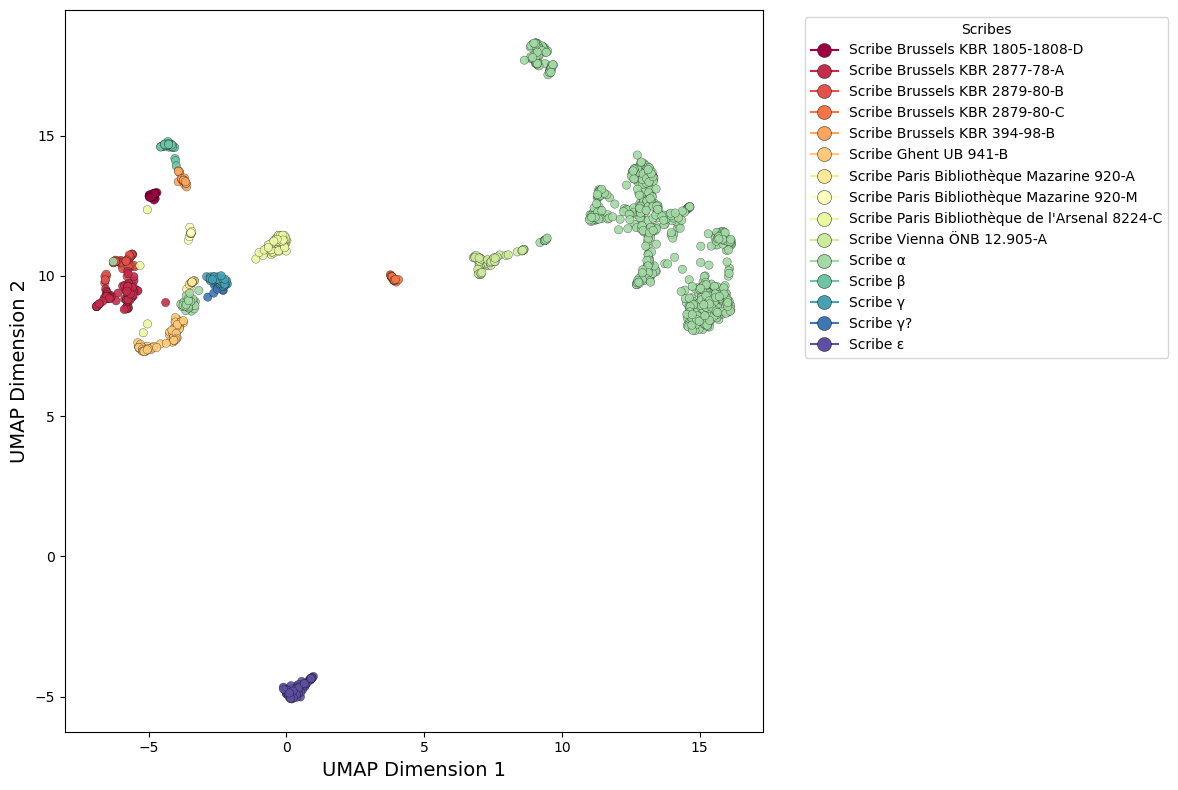

In [18]:
import umap.umap_ as umap

# Filter out scribes with less than 10 segments and exclude 'scribe3'
scribe_counts = segments['scribe'].value_counts()
filtered_scribes = scribe_counts[scribe_counts >= 10].index
# Exclude specific manuscripts based on the signatures
excluded_signatures = ['Brussels KBR 2979', 'Saint Petersburg BAN O 256']
filtered_segments = segments[
    (segments['scribe'].isin(filtered_scribes)) &
    (~segments['signature'].isin(excluded_signatures))
]

# Perform dimensionality reduction with PCA
pca_model = PCA(n_components=25)
X_pca = pca_model.fit_transform(BOW_df.loc[filtered_segments.index])

# Further reduction with UMAP
umap_model = umap.UMAP(n_components=2)
X_umap = umap_model.fit_transform(X_pca)

# Label encoding for scribes to color the scatter plot
label_encoder = LabelEncoder()
colors = label_encoder.fit_transform(filtered_segments['scribe'])

# Create a scatter plot with Matplotlib
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=colors, cmap='Spectral', alpha=0.9, edgecolor='black', linewidth=0.2)

# Creating a custom legend that matches the colors of the dots
scribe_labels = label_encoder.classes_
legend_handles = [plt.Line2D([0], [0], marker='o', color=scatter.cmap(scatter.norm(color)), label=f'Scribe {scribe}', markersize=10, markeredgecolor='black', markeredgewidth=0.3) for color, scribe in enumerate(scribe_labels)]

# Place the legend outside the plot on the right side, with a frame
plt.legend(handles=legend_handles, title="Scribes", bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True)

# Adding titles and labels with enhanced fonts
plt.xlabel('UMAP Dimension 1', fontsize=14)
plt.ylabel('UMAP Dimension 2', fontsize=14)
plt.grid(False)
plt.tight_layout()
plt.savefig('figures/scatterplot_2.svg', dpi=600, bbox_inches='tight')
plt.show()


### outlier detection analysis

In [19]:
# we select all segments attributed to scribe α
alpha = segments[(segments['scribe'] == 'α') & (segments['signature']!= 'Vienna ÖNB 65')].copy()

# apply TF-IDF Vectorizer
BOW = vectorizer.fit_transform(alpha['text']).toarray()

# standardize the BOW data for uniformity
BOW = preprocessing.scale(BOW)
BOW.shape

(672, 100)

In [20]:
# one-class SVM for outlier detection
one_class_svm = OneClassSVM().fit(BOW)
alpha['membership'] = one_class_svm.predict(BOW)

# counting membership values to identify outliers
alpha['membership'].value_counts()
alpha

,text,date,scribe,signature,id,translator,content,membership
608,\nHier beghent de tafele hoemē vēdē sal de ewp...,1387.5,α,Vienna ÖNB 12.857,Vienna ÖNB 12.857-II-α,NaN,perikopen,-1
658,m xjo\nHier beghent sente matheꝰ\nBMwoec der g...,1387.5,α,Vienna ÖNB 12.857,Vienna ÖNB 12.857-IV-α,NaN,evang,-1
659,eele vā galylea E comē\nde woende hi ī de sta...,1387.5,α,Vienna ÖNB 12.857,Vienna ÖNB 12.857-IV-α,NaN,evang,-1
660,ch si de ōtfarmhʼteghe wāt si selē\nde ōtfar...,1387.5,α,Vienna ÖNB 12.857,Vienna ÖNB 12.857-IV-α,NaN,evang,-1
661,n sal\ndine slinke hāt niet wetē wat di\nne re...,1387.5,α,Vienna ÖNB 12.857,Vienna ÖNB 12.857-IV-α,NaN,evang,1
...,...,...,...,...,...,...,...,...
1486,iewe dinc\nSint dꝫ ic kerstendoem ōtfīc\nHebbi...,1402.0,α,Vienna ÖNB 13.708,Vienna ÖNB 13.708-IV-α,NaN,sph2-2,1
1487,raet an nam\nAls hē dochte te siʼe orbarē\nDit...,1402.0,α,Vienna ÖNB 13.708,Vienna ÖNB 13.708-IV-α,NaN,sph2-2,1
1488,ōtfermēchede\nEs ontᵒest e vʼranesse mede\nS...,1402.0,α,Vienna ÖNB 13.708,Vienna ÖNB 13.708-IV-α,NaN,sph2-2,-1
1489,ᵃ\nVan den keyser aureliꝰ ꝯmodꝰ lvi\nDine tebe...,1402.0,α,Vienna ÖNB 13.708,Vienna ÖNB 13.708-IV-α,NaN,sph2-2,1


In [21]:
# We will now have a closer look at production units as a 
# whole instead of just the segments.

# For every production unit, we train a model. The model is
# always trained on all of the production units written by 
# alhpa, except for 1. The model is then tested on the 1 
# work we left out during training to test whether it was 
# written by α or not. For every segment we test this
# separately. At the end, you get a percentage of which 
# segments of the production units are anomalies and which are
# not

# analyzing purity of production units
purity = []

# looping through each production unit of α
for prod_unit, group in alpha.groupby('id'):
    train_X = BOW[alpha['id'] != prod_unit]
    one_class_svm = OneClassSVM().fit(train_X)

    # testing on the excluded unit
    test_X = BOW[alpha['id'] == prod_unit]
    membership = one_class_svm.predict(test_X)
    membs = Counter(membership)
    purity.append([prod_unit, group.iloc[0]['signature'], membs[-1] / len(group), membs[1] / len(group)])

purity = pd.DataFrame(purity, columns=['unit', 'codex', '-1', '+1'])
purity

,unit,codex,-1,+1
0,Brussels KBR 1805-1808-I-α,Brussels KBR 1805-1808,0.296296,0.703704
1,Brussels KBR 2849-51-I-α,Brussels KBR 2849-51,1.000000,0.000000
2,Brussels KBR 2849-51-II-α,Brussels KBR 2849-51,1.000000,0.000000
3,Brussels KBR 2849-51-III-α,Brussels KBR 2849-51,0.900000,0.100000
4,Brussels KBR 2849-51-IV-α,Brussels KBR 2849-51,1.000000,0.000000
5,Brussels KBR 2849-51-V-α,Brussels KBR 2849-51,0.615385,0.384615
6,Brussels KBR 2849-51-VI-α,Brussels KBR 2849-51,0.384615,0.615385
7,Brussels KBR 2849-51-VII-α,Brussels KBR 2849-51,0.321429,0.678571
8,Brussels KBR 2905-09-II-α,Brussels KBR 2905-09,0.454545,0.545455
9,Brussels KBR 3093-95-I-α,Brussels KBR 3093-95,0.800000,0.200000


In [22]:
codex_svm_results = purity.groupby('codex').agg({'-1': 'mean', '+1': 'mean'}).sort_values('-1', ascending=False)
codex_svm_results

,-1,+1
codex,,
Vienna ÖNB 12.857,0.927632,0.072368
Brussels KBR 3093-95,0.816667,0.183333
Brussels KBR 2849-51,0.745918,0.254082
Ghent UB 1374,0.631296,0.368704
Vienna ÖNB 13.708,0.575968,0.424032
Brussels KBR 2905-09,0.454545,0.545455
Brussels KBR 1805-1808,0.296296,0.703704


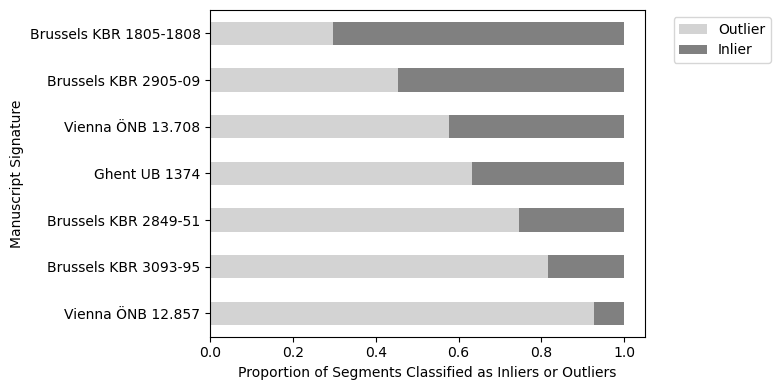

In [23]:
# Gray colours
colors = ['#d3d3d3', '#808080']

# Plotting a stacked bar chart with adjusted font size and layout
ax = codex_svm_results.plot(kind='barh', stacked=True, color=colors, figsize=(8, 4), fontsize=10)

# Setting plot title and labels
plt.xlabel('Proportion of Segments Classified as Inliers or Outliers', fontsize=10)
plt.ylabel('Manuscript Signature', fontsize=10)
plt.xticks(fontsize=10)

# Positioning the legend outside the plot on the right
plt.legend(labels=['Outlier', 'Inlier'], bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Show plot
plt.tight_layout()
plt.savefig('figures/outliers.png', format='png', dpi=1200)
plt.show()


In [24]:
# create list called 'classes' that labels each segment of alpha as either 'Vienna ÖNB 65' or 'rest', based on the signature column
classes = ['Vienna ÖNB 12.857' if sig == 'Vienna ÖNB 12.857' else 'rest' for sig in alpha['signature']]

feature_names = vectorizer.get_feature_names_out()

# rfc is used to differentiate between the 'Vienna ÖNB 65' class and 'rest'
# the model is trained on the BOW representation of the text
forest = RandomForestClassifier(random_state=0)
forest.fit(BOW, classes)

# after training, the importance of each feature in distinguishing between the two classes is calculated
# the stdev of the importances across all trees in the forest is also calculated
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

cutoff = 15
forest_importances = pd.Series(importances, index=feature_names)
std = pd.Series(std, index=feature_names)
forest_importances = forest_importances.sort_values(ascending=False).head(cutoff)[::-1]
std = forest_importances.loc[forest_importances.index].head(cutoff)[::-1]

forest_importances

wā    0.009373
ōm    0.010153
hʼ    0.012381
gʼ    0.017282
eʼ    0.019033
     0.019868
E    0.022947
ʼc    0.039109
ēd    0.041709
aʼ    0.066971
dꝫ    0.080630
ʼ     0.084383
hꝫ    0.093886
hē    0.114000
gē    0.189364
dtype: float64

/Users/carolinevandyck/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 58844 (\ue5dc) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/carolinevandyck/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 42859 (\N{LATIN SMALL LETTER ET}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


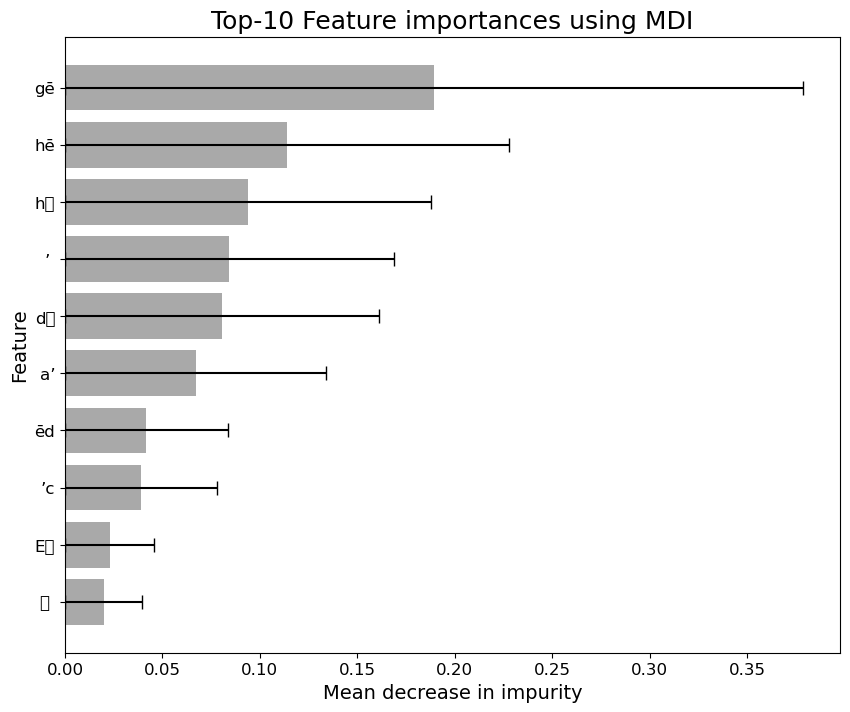

In [25]:
cutoff = 10
forest_importances = forest_importances.sort_values(ascending=False).head(cutoff)[::-1]
std = std.loc[forest_importances.index]

# Create a DataFrame from the feature importances and standard deviations
importance_data = pd.DataFrame({
    'feature': forest_importances.index,
    'importance': forest_importances.values,
    'importance_lower': forest_importances.values - std.values,
    'importance_upper': forest_importances.values + std.values
})

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))

bars = ax.barh(importance_data['feature'], importance_data['importance'], color='darkgrey')

# Adding error bars
for bar, lower, upper in zip(bars, importance_data['importance_lower'], importance_data['importance_upper']):
    ax.errorbar(x=bar.get_width(), y=bar.get_y() + bar.get_height() / 2,
                xerr=[[bar.get_width() - lower], [upper - bar.get_width()]],
                color='black', capsize=5)

# Set labels and title
ax.set_xlabel('Mean decrease in impurity', fontsize=14)
ax.set_ylabel('Feature', fontsize=14)
ax.set_title('Top-10 Feature importances using MDI')

# Customize fonts
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Top-10 Feature importances using MDI', fontsize=18)

plt.show()

In [26]:
BOW = pd.DataFrame(BOW, columns=feature_names)
BOW = BOW[forest_importances.index]
BOW.index = classes
BOW

,,E,ʼc,ēd,aʼ,dꝫ,ʼ,hꝫ,hē,gē
Vienna ÖNB 12.857,1.950506,3.549013,9.063979,1.513229,-0.833732,-1.517316,1.262482,1.954185,1.109233,-1.893804
Vienna ÖNB 12.857,2.184686,2.575287,-0.088505,2.162675,-0.807330,-1.533209,-1.666329,0.504562,0.904254,-1.220307
Vienna ÖNB 12.857,1.037010,0.949308,-0.402285,3.490418,-1.323713,-1.226726,-0.999118,3.705690,2.036010,-1.893804
Vienna ÖNB 12.857,-0.711336,-0.402968,-0.378260,0.234833,-1.208374,-1.304684,-1.757452,5.617169,1.437949,-1.893804
Vienna ÖNB 12.857,-0.510434,-0.625082,-0.695460,-0.127088,-1.211603,-1.309738,-1.472504,0.153981,1.289918,-1.893804
...,...,...,...,...,...,...,...,...,...,...
rest,0.099288,0.728230,-0.695460,-0.653570,0.268927,-0.677647,-0.853345,-0.613069,0.435299,0.125691
rest,-1.176846,-0.117980,-0.286231,-0.926897,1.067053,0.957043,0.220805,-0.613069,0.122475,-0.758570
rest,-0.880657,-0.596384,-0.185975,0.240194,1.849252,-0.562363,1.524594,0.012366,-0.057789,-0.480452
rest,1.293573,0.706993,-0.695460,-0.606803,1.774417,0.466185,0.569632,-0.613069,0.084896,0.039635


In [27]:
bow = pd.melt(BOW, value_vars=BOW.columns, ignore_index=False, var_name='abbreviation', value_name='score')
bow = bow.reset_index()
bow['origin'] = bow['index']
bow

,index,abbreviation,score,origin
0,Vienna ÖNB 12.857,,1.950506,Vienna ÖNB 12.857
1,Vienna ÖNB 12.857,,2.184686,Vienna ÖNB 12.857
2,Vienna ÖNB 12.857,,1.037010,Vienna ÖNB 12.857
3,Vienna ÖNB 12.857,,-0.711336,Vienna ÖNB 12.857
4,Vienna ÖNB 12.857,,-0.510434,Vienna ÖNB 12.857
...,...,...,...,...
6715,rest,gē,0.125691,rest
6716,rest,gē,-0.758570,rest
6717,rest,gē,-0.480452,rest
6718,rest,gē,0.039635,rest


In [28]:
bow['abbreviation'].unique()

array(['\ue5dc ', 'E\ue5dc', 'ʼc', 'ēd', 'aʼ', 'dꝫ', 'ʼ ', 'hꝫ', 'hē',
       'gē'], dtype=object)

findfont: Font family 'Cardo' not found.
findfont: Font family 'Cardo' not found.
/var/folders/qv/jgq1ttws58g43xdmt2gthgth0000gn/T/ipykernel_59674/3583181829.py:25: UserWarning: Glyph 58844 (\ue5dc) missing from current font.
  plt.savefig('figures/boxplot.pdf', dpi=600, bbox_inches='tight')
findfont: Font family 'Cardo' not found.
findfont: Font family 'Cardo' not found.
findfont: Font family 'Cardo' not found.
findfont: Font family 'Cardo' not found.
findfont: Font family 'Cardo' not found.
/var/folders/qv/jgq1ttws58g43xdmt2gthgth0000gn/T/ipykernel_59674/3583181829.py:25: UserWarning: Glyph 42859 (\N{LATIN SMALL LETTER ET}) missing from current font.
  plt.savefig('figures/boxplot.pdf', dpi=600, bbox_inches='tight')
findfont: Font family 'Cardo' not found.
findfont: Font family 'Cardo' not found.
findfont: Font family 'Cardo' not found.
findfont: Font family 'Cardo' not found.
findfont: Font family 'Junicode' not found.
findfont: Font family 'Junicode' not found.
findfont: Font famil

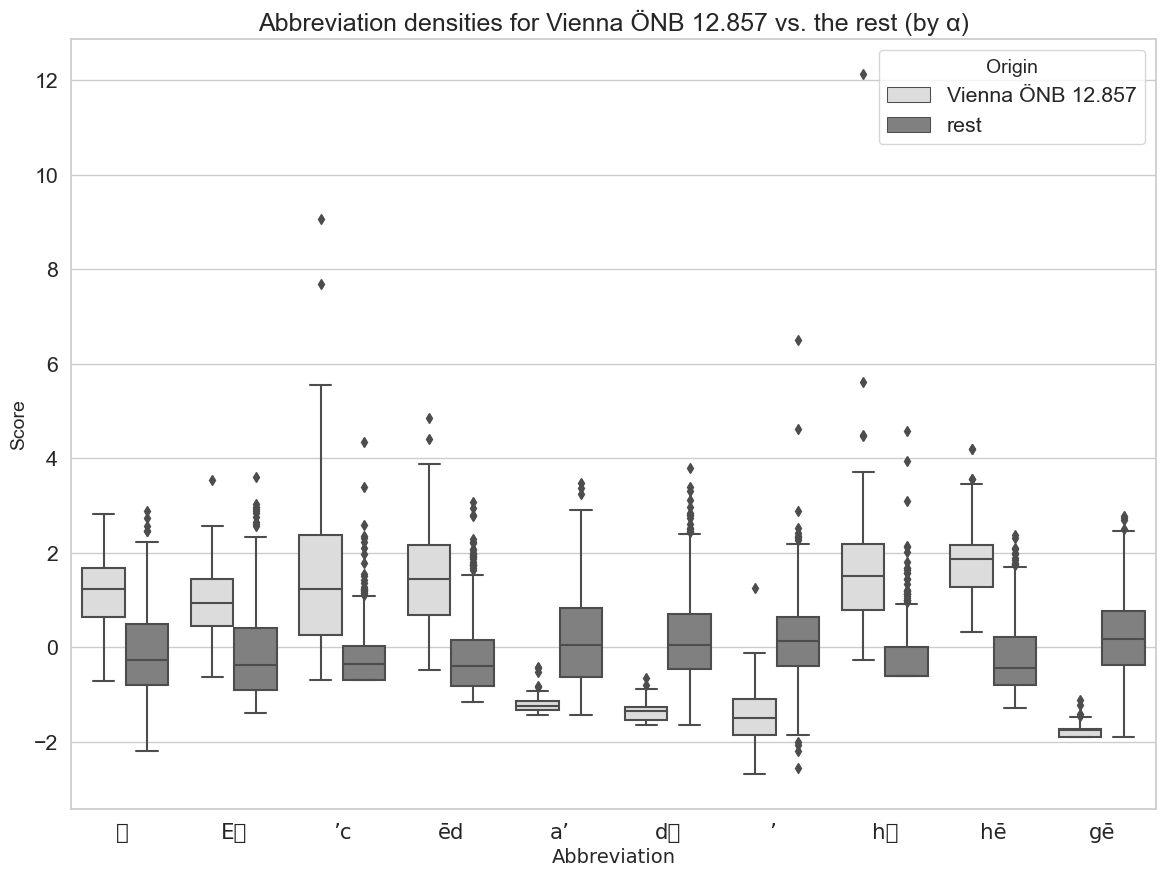

In [29]:
# Set the font style
# set cardo to be the default font for special glyphs
plt.rcParams["font.family"] = "Cardo"
sns.set(style="whitegrid", font_scale=1.4)

# Define a custom color palette with two colors using names
custom_palette = ["gainsboro", "gray"]

# Plotting
plt.figure(figsize=(14, 10))

# Create a boxplot with 'abbreviation' on the x-axis, 'score' on the y-axis, and 'origin' as hue
sns.boxplot(x='abbreviation', y='score', hue='origin', data=bow, palette=custom_palette)

# Set labels and title
plt.xlabel('Abbreviation', fontsize=14, fontname='Junicode')
plt.ylabel('Score', fontsize=14)
plt.title('Abbreviation densities for Vienna ÖNB 12.857 vs. the rest (by α)', fontsize=18)

# Show the legend
plt.legend(title='Origin', title_fontsize='14')

# Set the x-axis labels to use the Junicode font
plt.xticks(fontname='Cardo')
plt.savefig('figures/boxplot.pdf', dpi=600, bbox_inches='tight')
plt.show()

Repeating the same analysis for the work he copied last: 13.708. Does he use d3 here more than expected?

In [30]:
# we select all segments attributed to scribe α
alpha = segments[(segments['scribe'] == 'α') & (segments['signature']!= 'Vienna ÖNB 65')].copy()

# apply TF-IDF Vectorizer
BOW = vectorizer.fit_transform(alpha['text']).toarray()

# standardize the BOW data for uniformity
BOW = preprocessing.scale(BOW)
BOW.shape

(672, 100)

In [31]:
# create list called 'classes' that labels each segment of alpha as either 'Vienna ÖNB 65' or 'rest', based on the signature column
classes = ['Vienna ÖNB 13.708' if sig == 'Vienna ÖNB 13.708' else 'rest' for sig in alpha['signature']]

feature_names = vectorizer.get_feature_names_out()

# rfc is used to differentiate between the 'Vienna ÖNB 65' class and 'rest'
# the model is trained on the BOW representation of the text
forest = RandomForestClassifier(random_state=0)
forest.fit(BOW, classes)

# after training, the importance of each feature in distinguishing between the two classes is calculated
# the stdev of the importances across all trees in the forest is also calculated
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

cutoff = 15
forest_importances = pd.Series(importances, index=feature_names)
std = pd.Series(std, index=feature_names)
forest_importances = forest_importances.sort_values(ascending=False).head(cutoff)[::-1]
std = forest_importances.loc[forest_importances.index].head(cutoff)[::-1]

forest_importances

ᵃc    0.018250
ᵒt    0.019301
hꝫ    0.020882
mʼ    0.021145
rē    0.021220
ʼ     0.022386
ʼs    0.022874
ᵗ     0.027312
e    0.029570
E    0.035820
mē    0.037227
ꝰ     0.042326
wā    0.043771
Vā    0.061958
aʼ    0.089560
dtype: float64

/Users/carolinevandyck/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 58844 (\ue5dc) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/carolinevandyck/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 42864 (\N{MODIFIER LETTER US}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


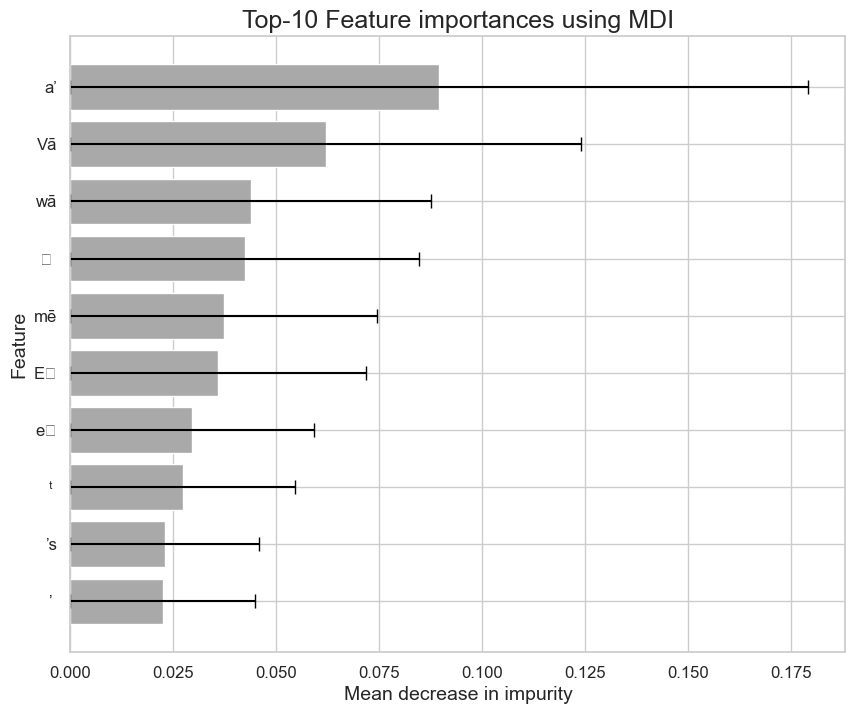

In [32]:
cutoff = 10
forest_importances = forest_importances.sort_values(ascending=False).head(cutoff)[::-1]
std = std.loc[forest_importances.index]

# Create a DataFrame from the feature importances and standard deviations
importance_data = pd.DataFrame({
    'feature': forest_importances.index,
    'importance': forest_importances.values,
    'importance_lower': forest_importances.values - std.values,
    'importance_upper': forest_importances.values + std.values
})

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))

bars = ax.barh(importance_data['feature'], importance_data['importance'], color='darkgrey')

# Adding error bars
for bar, lower, upper in zip(bars, importance_data['importance_lower'], importance_data['importance_upper']):
    ax.errorbar(x=bar.get_width(), y=bar.get_y() + bar.get_height() / 2,
                xerr=[[bar.get_width() - lower], [upper - bar.get_width()]],
                color='black', capsize=5)

# Set labels and title
ax.set_xlabel('Mean decrease in impurity', fontsize=14)
ax.set_ylabel('Feature', fontsize=14)
ax.set_title('Top-10 Feature importances using MDI')

# Customize fonts
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Top-10 Feature importances using MDI', fontsize=18)

plt.show()

In [33]:
BOW = pd.DataFrame(BOW, columns=feature_names)
BOW = BOW[forest_importances.index]
BOW.index = classes
BOW

,ʼ,ʼs,ᵗ,e,E,mē,ꝰ,wā,Vā,aʼ
rest,1.262482,-1.106157,-0.758519,-1.386860,3.549013,0.633746,0.507957,-0.401139,-0.219170,-0.833732
rest,-1.666329,-1.177993,-0.884597,0.147433,2.575287,-1.382239,-0.320051,2.561183,-0.420237,-0.807330
rest,-0.999118,1.375418,-1.030565,0.333194,0.949308,-0.825438,-0.592202,2.217149,-0.420237,-1.323713
rest,-1.757452,1.118772,-0.719461,-0.529913,-0.402968,-0.245473,-0.301899,3.206848,-0.420237,-1.208374
rest,-1.472504,-1.163736,-0.110524,0.004200,-0.625082,-0.894563,-0.721464,0.983778,-0.420237,-1.211603
...,...,...,...,...,...,...,...,...,...,...
Vienna ÖNB 13.708,-0.853345,0.876317,-1.006223,-0.665662,0.728230,-0.328144,3.892516,-0.936809,1.154578,0.268927
Vienna ÖNB 13.708,0.220805,0.294948,-1.079369,-1.447618,-0.117980,3.148187,1.263274,-0.936809,0.287973,1.067053
Vienna ÖNB 13.708,1.524594,0.774291,-0.511950,-0.609130,-0.596384,1.659487,2.198779,-0.936809,0.461476,1.849252
Vienna ÖNB 13.708,0.569632,0.718579,0.056903,0.689751,0.706993,0.583756,0.595515,-0.936809,0.441311,1.774417


In [34]:
bow = pd.melt(BOW, value_vars=BOW.columns, ignore_index=False, var_name='abbreviation', value_name='score')
bow = bow.reset_index()
bow['origin'] = bow['index']
bow

,index,abbreviation,score,origin
0,rest,ʼ,1.262482,rest
1,rest,ʼ,-1.666329,rest
2,rest,ʼ,-0.999118,rest
3,rest,ʼ,-1.757452,rest
4,rest,ʼ,-1.472504,rest
...,...,...,...,...
6715,Vienna ÖNB 13.708,aʼ,0.268927,Vienna ÖNB 13.708
6716,Vienna ÖNB 13.708,aʼ,1.067053,Vienna ÖNB 13.708
6717,Vienna ÖNB 13.708,aʼ,1.849252,Vienna ÖNB 13.708
6718,Vienna ÖNB 13.708,aʼ,1.774417,Vienna ÖNB 13.708


findfont: Font family 'Cardo' not found.
findfont: Font family 'Cardo' not found.
findfont: Font family 'Cardo' not found.
findfont: Font family 'Cardo' not found.
findfont: Font family 'Cardo' not found.
/var/folders/qv/jgq1ttws58g43xdmt2gthgth0000gn/T/ipykernel_59674/3025450533.py:25: UserWarning: Glyph 58844 (\ue5dc) missing from current font.
  plt.savefig('figures/boxplot.pdf', dpi=600, bbox_inches='tight')
findfont: Font family 'Cardo' not found.
findfont: Font family 'Cardo' not found.
findfont: Font family 'Cardo' not found.
/var/folders/qv/jgq1ttws58g43xdmt2gthgth0000gn/T/ipykernel_59674/3025450533.py:25: UserWarning: Glyph 42864 (\N{MODIFIER LETTER US}) missing from current font.
  plt.savefig('figures/boxplot.pdf', dpi=600, bbox_inches='tight')
findfont: Font family 'Cardo' not found.
findfont: Font family 'Cardo' not found.
findfont: Font family 'Cardo' not found.
findfont: Font family 'Junicode' not found.
findfont: Font family 'Junicode' not found.
findfont: Font family '

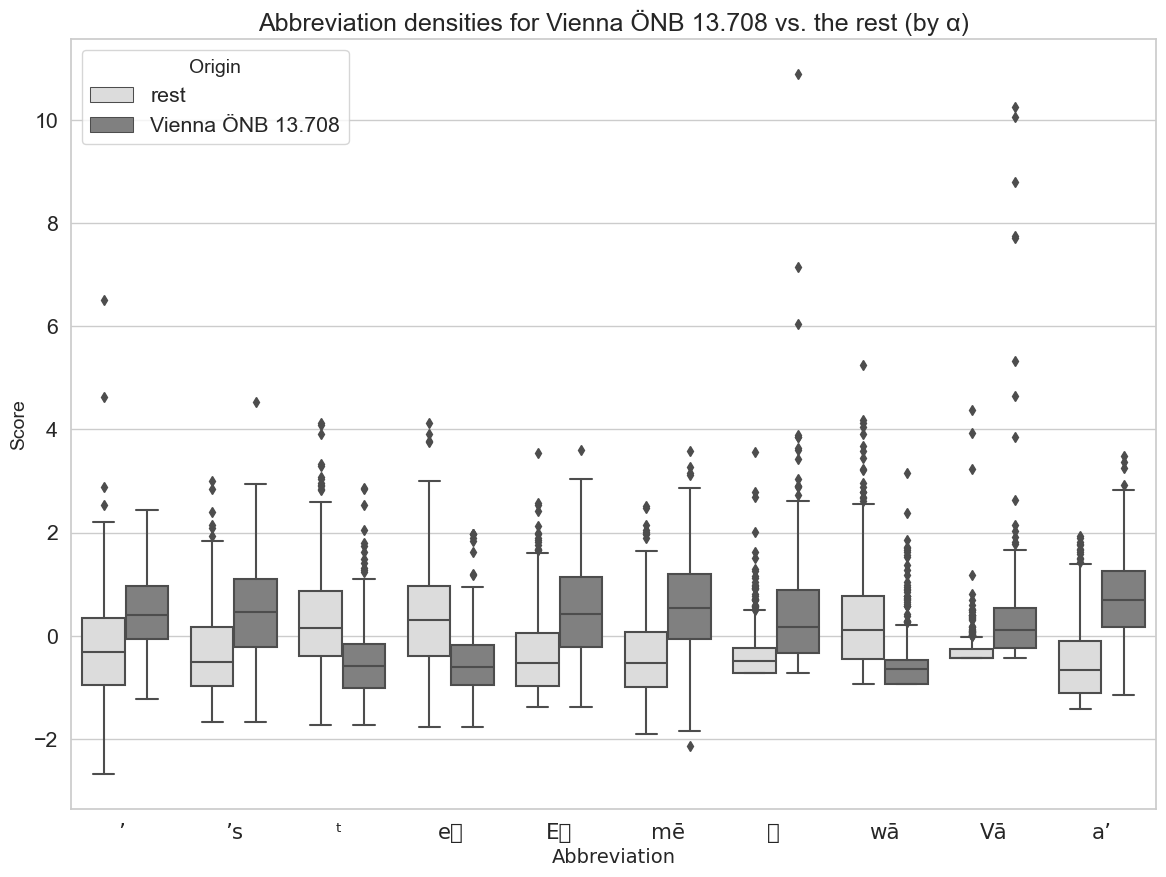

In [35]:
# Set the font style
# set cardo to be the default font for special glyphs
plt.rcParams["font.family"] = "Cardo"
sns.set(style="whitegrid", font_scale=1.4)

# Define a custom color palette with two colors using names
custom_palette = ["gainsboro", "gray"]

# Plotting
plt.figure(figsize=(14, 10))

# Create a boxplot with 'abbreviation' on the x-axis, 'score' on the y-axis, and 'origin' as hue
sns.boxplot(x='abbreviation', y='score', hue='origin', data=bow, palette=custom_palette)

# Set labels and title
plt.xlabel('Abbreviation', fontsize=14, fontname='Junicode')
plt.ylabel('Score', fontsize=14)
plt.title('Abbreviation densities for Vienna ÖNB 13.708 vs. the rest (by α)', fontsize=18)

# Show the legend
plt.legend(title='Origin', title_fontsize='14')

# Set the x-axis labels to use the Junicode font
plt.xticks(fontname='Cardo')
plt.savefig('figures/boxplot.pdf', dpi=600, bbox_inches='tight')
plt.show()

He does not use d3 here more than expected. The shift happened elsewhere.

In [36]:
import re

# Filteren op de rijen met signature "Vienna ÖNB 12.857"
vienna_12857_rows = alpha[alpha['signature'] == 'Vienna ÖNB 12.857']

# Alle tekstrijen samenvoegen
combined_text = '\n'.join(vienna_12857_rows['text'])

# Zoek naar matches van de reguliere expressie
matches = re.finditer(r' dꝫ(?![a-zA-Z])|(?<=\n)Dꝫ(?![a-zA-Z])', combined_text)

# Voor elke match, print 40 tekens ervoor en erna
for match in matches:
    start_index = max(0, match.start() - 40)  # Begin van het blok van 40 tekens voor de match
    end_index = min(len(combined_text), match.end() + 40)  # Einde van het blok van 40 tekens na de match
    print(combined_text[start_index:match.start()], end='')  # Print 40 tekens voor de match
    print(combined_text[match.start():match.end()], end='')  # Print de match zelf
    print(combined_text[match.end():end_index])  # Print 40 tekens na de match




de iordane dʼ liede vā galylea Dat volc dꝫ
ī dōkʼnessē wādelde sach groet licht  E
 warē  de welke nᵗ gheorlouet ē wa
cxxi
Dꝫ
Lu
rē tetene dā allene dē priesterē E 
īghʼ gods ute wʼpe de duueA
Lu
cxxxix
e dꝫ hueden

cas
le  so cōt haesteleke ī n d
ewedʼ sake ī dē weghe tē prīcē doꝫ alsoe dꝫ
ghi ghevrijt wʼt vā hē dat hi di malich
hē  Wi heb
bē vondē messyam dat es bedie dꝫ xc E
hi leidde hē te ihʼm Jhʼc ane sa
maʼ
die waerhᵗ wʼket hi cōt tē lichte op dꝫ
sine wʼke wʼdē gheopēbaʼt  Wāt si si i

gheloeuē  wāt hi screef vā mi  Wāt eest dꝫ
ghi sinē lettʼen nᵗ ē gheloeuꝫ hoe soud
i
biddet ī minē name dat salic doē  Eest dꝫ
ghi mi mīt houdꝫ mine ghebode e ic
sal


In [37]:
import re

# Functie om het aantal voorkomens van 'dꝫ' en de opgegeven regex te tellen, zonder letters ervoor of erna
def count_characters(text):
    # Vind alle overeenkomsten van 'dꝫ' zonder letters ervoor of erna
    dit_dat = re.findall(r' dꝫ(?![a-zA-Z])|(?<=\n)Dꝫ(?![a-zA-Z])', text)
    # Vind alle overeenkomsten van de opgegeven regex zonder letters ervoor of erna
    all_d3 = re.findall(r'dꝫ|Dꝫ', text)
    return len(dit_dat) / len(all_d3)

# Groepeer 'text' op basis van 'signature' en 'date' en tel het aantal keer dat 'dꝫ' en de opgegeven regex voorkomen zonder letters ervoor of erna
character_counts = alpha.groupby(['signature', 'date'])['text'].apply(lambda x: count_characters(''.join(x))).reset_index(name='character_counts')

# Toon de resulterende DataFrame
print(character_counts)

                signature    date  character_counts
0  Brussels KBR 1805-1808  1395.0          0.891662
1    Brussels KBR 2849-51  1387.5          0.892153
2    Brussels KBR 2905-09  1387.5          0.894649
3    Brussels KBR 3093-95  1387.5          0.780797
4           Ghent UB 1374  1387.5          0.581020
5       Vienna ÖNB 12.857  1387.5          0.039024
6       Vienna ÖNB 13.708  1393.0          0.927386
7       Vienna ÖNB 13.708  1393.5          0.878296
8       Vienna ÖNB 13.708  1394.0          0.843054
9       Vienna ÖNB 13.708  1402.0          0.979353


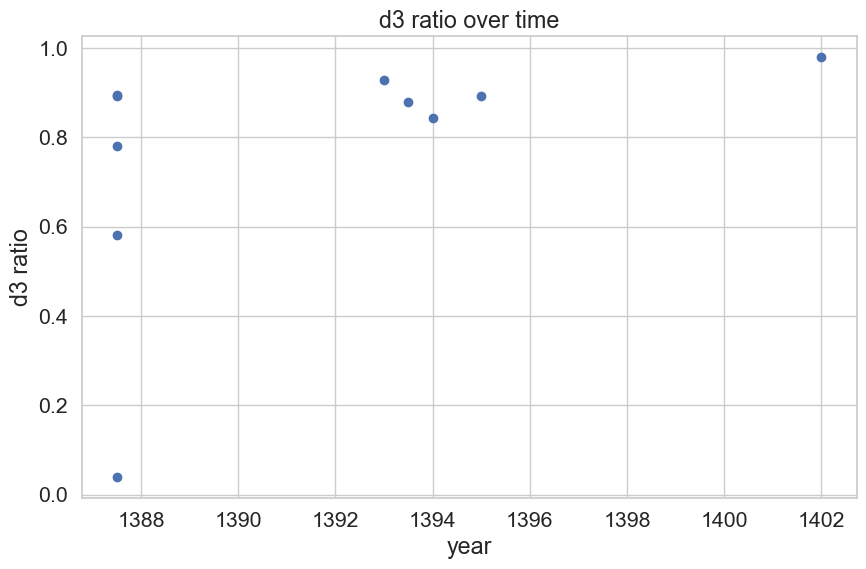

In [38]:
import matplotlib.pyplot as plt

# Creëer een scatterplot van date met d3_ratio op de y-as en date op de x-as
plt.figure(figsize=(10, 6))  # Optioneel: pas de grootte van de grafiek aan
plt.scatter(character_counts['date'], character_counts['character_counts'], marker='o', linestyle='-')

# Voeg labels toe aan de assen en een titel toe aan de grafiek
plt.xlabel('year')
plt.ylabel('d3 ratio')
plt.title('d3 ratio over time')

# Toon de grafiek
plt.grid(True)  # Optioneel: voeg een grid toe voor betere visualisatie
plt.show()


colofons in Brussel KB 1805-08 (1395) en Wenen ÖNB Cod. 13.708 (1393. 1394 en 1402); 2. de periode waarin zijn werkpartner de Necrologium-kopiist actief was, van tenminste 1373 tot 1396 (zie de dateringen in K2.3-2.5); 

In [39]:
HS = segments[(segments['scribe'] == 'α') & (segments['signature']!= 'Vienna ÖNB 65') & (segments['signature']== 'Ghent UB 1374')].copy()
HS

,text,date,scribe,signature,id,translator,content
1039,Jn dierste partie vā dē spiegele hystoriale Jn...,1387.5,α,Ghent UB 1374,Ghent UB 1374-II-α,NaN,SpH1_8 - SpH1_8-SpH2_1 - SpH2_1 - SpH2_1-SpH3_...
1040,ī \ndu dē ge\ne mꝫ ca\nSie datt \nniene be\nv...,1387.5,α,Ghent UB 1374,Ghent UB 1374-II-α,NaN,SpH1_8 - SpH1_8-SpH2_1 - SpH2_1 - SpH2_1-SpH3_...
1041,negeenē male Eest\ndattu mate houdē wilt Al...,1387.5,α,Ghent UB 1374,Ghent UB 1374-II-α,NaN,SpH1_8 - SpH1_8-SpH2_1 - SpH2_1 - SpH2_1-SpH3_...
1042,oꝫ dē goedē mā So cleenē\ndiēst geenē godweet...,1387.5,α,Ghent UB 1374,Ghent UB 1374-II-α,NaN,SpH1_8 - SpH1_8-SpH2_1 - SpH2_1 - SpH2_1-SpH3_...
1043,ē Want\nmē machʼ nᵗ ōtfliē Mʼ daʼ iegē si s...,1387.5,α,Ghent UB 1374,Ghent UB 1374-II-α,NaN,SpH1_8 - SpH1_8-SpH2_1 - SpH2_1 - SpH2_1-SpH3_...
...,...,...,...,...,...,...,...
1125,one Berecht mi nv vā den\nꝑsone Die mē heet ...,1387.5,α,Ghent UB 1374,Ghent UB 1374-III-α,NaN,SpH4_5 - SpH4_5-eerstemartijn - eerstemartijn ...
1126,boese dade Werde god laꝫ ōs ver\ndingē Onse...,1387.5,α,Ghent UB 1374,Ghent UB 1374-III-α,NaN,SpH4_5 - SpH4_5-eerstemartijn - eerstemartijn ...
1127,e tᵉkē Dꝫ hʼen mettē mō\nde spᵉkē Dies \nsi\...,1387.5,α,Ghent UB 1374,Ghent UB 1374-III-α,NaN,SpH4_5 - SpH4_5-eerstemartijn - eerstemartijn ...
1128,scout Vā sinē mesdadē Mʼtē ochtu dich\n\n\n\...,1387.5,α,Ghent UB 1374,Ghent UB 1374-III-α,NaN,SpH4_5 - SpH4_5-eerstemartijn - eerstemartijn ...


In [40]:
import re

# Functie om het aantal voorkomens van 'dꝫ' en de opgegeven regex te tellen, zonder letters ervoor of erna
def count_characters(text):
    # Vind alle overeenkomsten van 'dꝫ' zonder letters ervoor of erna
    dit_dat = re.findall(r' dꝫ(?![a-zA-Z])|(?<=\n)Dꝫ(?![a-zA-Z])', text)
    # Vind alle overeenkomsten van de opgegeven regex zonder letters ervoor of erna
    all_d3 = re.findall(r'dꝫ|Dꝫ', text)
    return len(dit_dat) / len(all_d3)

# Groepeer 'text' op basis van 'signature' en 'date' en tel het aantal keer dat 'dꝫ' en de opgegeven regex voorkomen zonder letters ervoor of erna
character_counts = HS.groupby(['id', 'date'])['text'].apply(lambda x: count_characters(''.join(x))).reset_index(name='character_counts')

# Toon de resulterende DataFrame
print(character_counts)

                    id    date  character_counts
0    Ghent UB 1374-I-α  1387.5          0.575758
1   Ghent UB 1374-II-α  1387.5          0.569069
2  Ghent UB 1374-III-α  1387.5          0.565657
3   Ghent UB 1374-IV-α  1387.5          0.650224
4    Ghent UB 1374-V-α  1387.5          0.666667


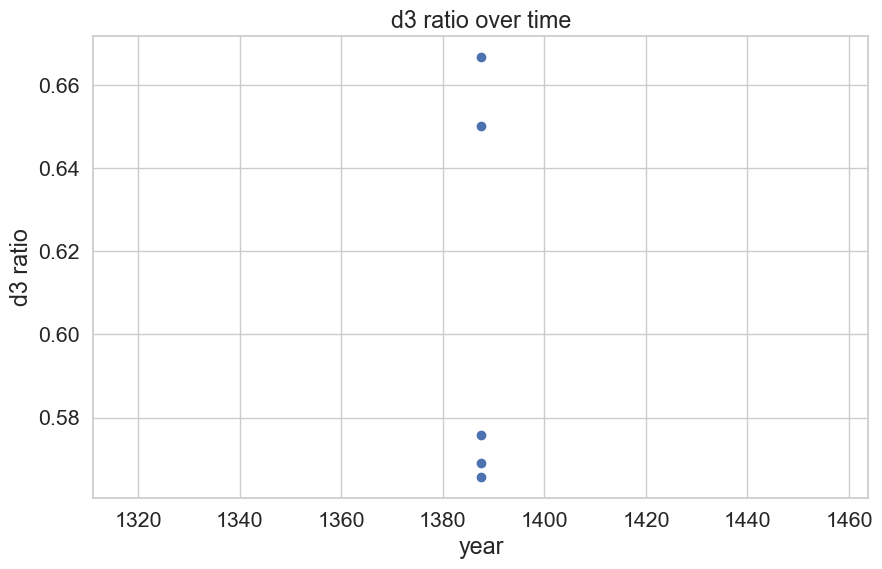

In [41]:
import matplotlib.pyplot as plt

# Creëer een scatterplot van date met d3_ratio op de y-as en date op de x-as
plt.figure(figsize=(10, 6))  # Optioneel: pas de grootte van de grafiek aan
plt.scatter(character_counts['date'], character_counts['character_counts'], marker='o', linestyle='-')

# Voeg labels toe aan de assen en een titel toe aan de grafiek
plt.xlabel('year')
plt.ylabel('d3 ratio')
plt.title('d3 ratio over time')

# Toon de grafiek
plt.grid(True)  # Optioneel: voeg een grid toe voor betere visualisatie
plt.show()


In [42]:
vienna = segments[(segments['scribe'] == 'α') & (segments['signature']!= 'Vienna ÖNB 65') & (segments['signature']== 'Vienna ÖNB 13.708')].copy()
vienna

,text,date,scribe,signature,id,translator,content
1133,a\nDoemē screef mccc e xcvi\nop de derde none...,1393.0,α,Vienna ÖNB 13.708,Vienna ÖNB 13.708-II-α,NaN,kroniekbrabant - sph4 - lekenspiegel - corpusi...
1134,e wʼden wi vermaēt na dexēpel\nvan dē machabee...,1393.0,α,Vienna ÖNB 13.708,Vienna ÖNB 13.708-II-α,NaN,kroniekbrabant - sph4 - lekenspiegel - corpusi...
1135,maede xx dage e twee\n\nNoᵃ\nDꝫ geen wijf ē ...,1393.0,α,Vienna ÖNB 13.708,Vienna ÖNB 13.708-II-α,NaN,kroniekbrabant - sph4 - lekenspiegel - corpusi...
1136,mē dʼ martelarē vite\nBescⁱuē soude met vlite...,1393.0,α,Vienna ÖNB 13.708,Vienna ÖNB 13.708-II-α,NaN,kroniekbrabant - sph4 - lekenspiegel - corpusi...
1137,at\nDijftiē cardinale ōme dat\nNoᵃ Si vᵒech e...,1393.0,α,Vienna ÖNB 13.708,Vienna ÖNB 13.708-II-α,NaN,kroniekbrabant - sph4 - lekenspiegel - corpusi...
...,...,...,...,...,...,...,...
1486,iewe dinc\nSint dꝫ ic kerstendoem ōtfīc\nHebbi...,1402.0,α,Vienna ÖNB 13.708,Vienna ÖNB 13.708-IV-α,NaN,sph2-2
1487,raet an nam\nAls hē dochte te siʼe orbarē\nDit...,1402.0,α,Vienna ÖNB 13.708,Vienna ÖNB 13.708-IV-α,NaN,sph2-2
1488,ōtfermēchede\nEs ontᵒest e vʼranesse mede\nS...,1402.0,α,Vienna ÖNB 13.708,Vienna ÖNB 13.708-IV-α,NaN,sph2-2
1489,ᵃ\nVan den keyser aureliꝰ ꝯmodꝰ lvi\nDine tebe...,1402.0,α,Vienna ÖNB 13.708,Vienna ÖNB 13.708-IV-α,NaN,sph2-2


In [43]:
import re

# Functie om het aantal voorkomens van 'dꝫ' en de opgegeven regex te tellen, zonder letters ervoor of erna
def count_characters(text):
    # Vind alle overeenkomsten van 'dꝫ' zonder letters ervoor of erna
    dit_dat = re.findall(r' dꝫ(?![a-zA-Z])|(?<=\n)Dꝫ(?![a-zA-Z])', text)
    # Vind alle overeenkomsten van de opgegeven regex zonder letters ervoor of erna
    all_d3 = re.findall(r'dꝫ|Dꝫ', text)
    return len(dit_dat) / len(all_d3)

# Groepeer 'text' op basis van 'signature' en 'date' en tel het aantal keer dat 'dꝫ' en de opgegeven regex voorkomen zonder letters ervoor of erna
character_counts = vienna.groupby(['id', 'date'])['text'].apply(lambda x: count_characters(''.join(x))).reset_index(name='character_counts')

# Toon de resulterende DataFrame
print(character_counts)

                          id    date  character_counts
0      Vienna ÖNB 13.708-I-α  1402.0          0.877049
1     Vienna ÖNB 13.708-II-α  1393.0          0.927386
2    Vienna ÖNB 13.708-III-α  1402.0          0.990385
3     Vienna ÖNB 13.708-IV-α  1402.0          0.977477
4     Vienna ÖNB 13.708-IX-α  1402.0          0.983784
5      Vienna ÖNB 13.708-V-α  1402.0          0.994350
6     Vienna ÖNB 13.708-VI-α  1402.0          0.981735
7    Vienna ÖNB 13.708-VII-α  1402.0          0.983051
8   Vienna ÖNB 13.708-VIII-α  1402.0          0.994505
9      Vienna ÖNB 13.708-X-α  1393.5          0.878296
10    Vienna ÖNB 13.708-XI-α  1394.0          0.843054


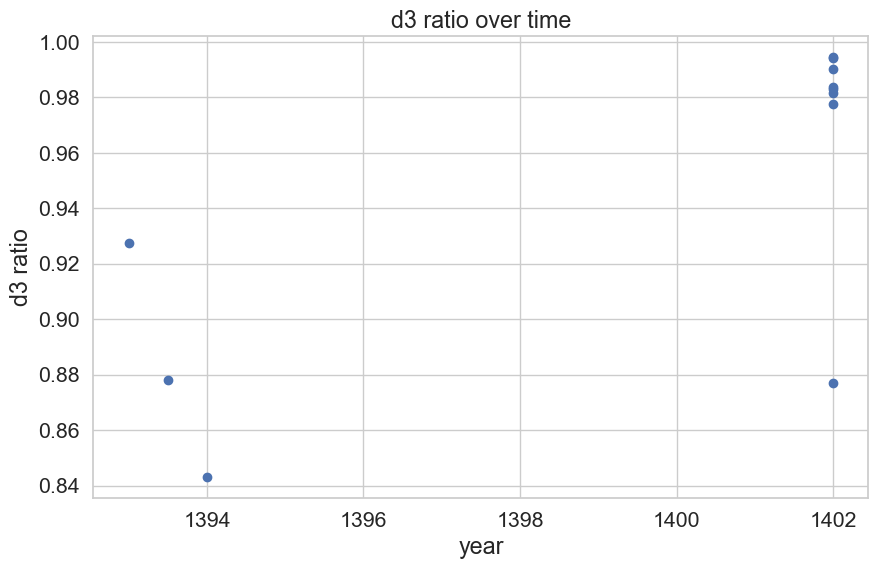

In [44]:
import matplotlib.pyplot as plt

# Creëer een scatterplot van date met d3_ratio op de y-as en date op de x-as
plt.figure(figsize=(10, 6))  # Optioneel: pas de grootte van de grafiek aan
plt.scatter(character_counts['date'], character_counts['character_counts'], marker='o', linestyle='-')

# Voeg labels toe aan de assen en een titel toe aan de grafiek
plt.xlabel('year')
plt.ylabel('d3 ratio')
plt.title('d3 ratio over time')

# Toon de grafiek
plt.grid(True)  # Optioneel: voeg een grid toe voor betere visualisatie
plt.show()

1402: Biemans meent dat de eerste productie-eenheid (f. 1-5) reeds in 1394 kan zijn toegevoegd bgl. Biemans 1997, deel 1, p. 117 en 119). Dit lijkt mij niet erg waarschijnlijk gezien de con-
emporaine foliering (‘1’) op het laatste blad van die eenheid (f. 5 modem), die pas werd aange- racht nadat de elf delen rond 1402 werden .samengebonden.

In [45]:
import re

# Functie om het aantal voorkomens van 'dꝫ' en de opgegeven regex te tellen, zonder letters ervoor of erna
def count_characters(text):
    # Vind alle overeenkomsten van 'dꝫ' zonder letters ervoor of erna
    dit_dat = re.findall(r' dꝫ(?![a-zA-Z])|(?<=\n)Dꝫ(?![a-zA-Z])', text)
    # Vind alle overeenkomsten van de opgegeven regex zonder letters ervoor of erna
    all_d3 = re.findall(r'dꝫ|Dꝫ', text)
    return len(dit_dat) / len(all_d3)

# Groepeer 'text' op basis van 'signature' en 'date' en tel het aantal keer dat 'dꝫ' en de opgegeven regex voorkomen zonder letters ervoor of erna
character_counts = alpha.groupby(['id', 'date'])['text'].apply(lambda x: count_characters(''.join(x))).reset_index(name='character_counts')

# Toon de resulterende DataFrame
print(character_counts)

                            id    date  character_counts
0   Brussels KBR 1805-1808-I-α  1395.0          0.891662
1     Brussels KBR 2849-51-I-α  1387.5          1.000000
2    Brussels KBR 2849-51-II-α  1387.5          0.857143
3   Brussels KBR 2849-51-III-α  1387.5          0.891892
4    Brussels KBR 2849-51-IV-α  1387.5          0.933333
5     Brussels KBR 2849-51-V-α  1387.5          0.906651
6    Brussels KBR 2849-51-VI-α  1387.5          0.826955
7   Brussels KBR 2849-51-VII-α  1387.5          0.921053
8    Brussels KBR 2905-09-II-α  1387.5          0.894649
9     Brussels KBR 3093-95-I-α  1387.5          0.846626
10   Brussels KBR 3093-95-II-α  1387.5          0.753213
11           Ghent UB 1374-I-α  1387.5          0.575758
12          Ghent UB 1374-II-α  1387.5          0.569069
13         Ghent UB 1374-III-α  1387.5          0.565657
14          Ghent UB 1374-IV-α  1387.5          0.650224
15           Ghent UB 1374-V-α  1387.5          0.666667
16      Vienna ÖNB 12.857-II-α 

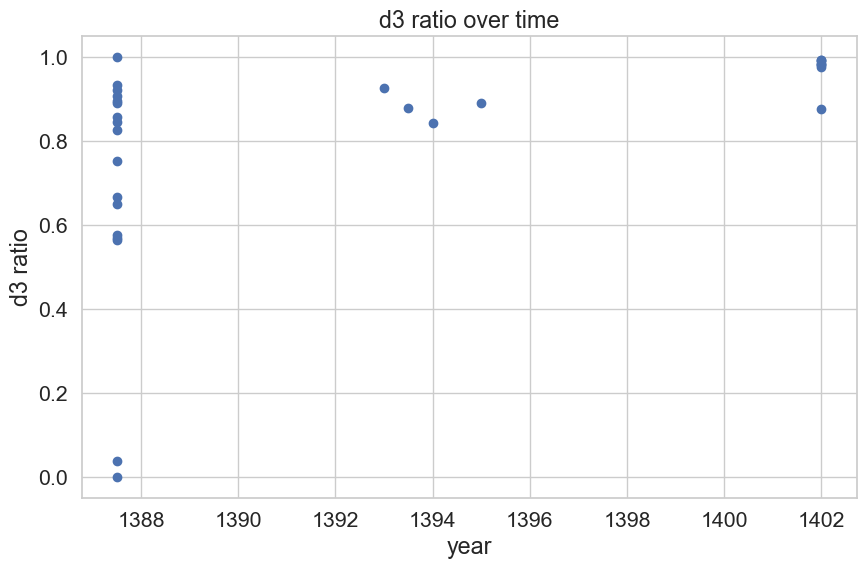

In [46]:
import matplotlib.pyplot as plt

# Creëer een scatterplot van date met d3_ratio op de y-as en date op de x-as
plt.figure(figsize=(10, 6))  # Optioneel: pas de grootte van de grafiek aan
plt.scatter(character_counts['date'], character_counts['character_counts'], marker='o', linestyle='-')

# Voeg labels toe aan de assen en een titel toe aan de grafiek
plt.xlabel('year')
plt.ylabel('d3 ratio')
plt.title('d3 ratio over time')

# Toon de grafiek
plt.grid(True)  # Optioneel: voeg een grid toe voor betere visualisatie
plt.show()